In [1]:
from pathlib import Path

dataset_path = Path(r'/home/thor/Desktop/datasets/kdef/original/KDEF-HRS-organized421414-cropped16400-occluded')
training_set_path = dataset_path / 'training_set'
validation_set_path = dataset_path / 'validation_set'
test_set_path = dataset_path / 'test_set'

id_to_emotion = {
    0: 'Neutral',
    1: 'Happy',
    2: 'Sad',
    3: 'Surprise',
    4: 'Fear',
    5: 'Disgust',
    6: 'Anger',
}


In [2]:
def compute_class_frequencies(dataset_path: Path) -> dict:
    class_frequencies = {}
    for class_dir in sorted(dataset_path.iterdir()):
        num_files = sum(1 for _ in class_dir.iterdir())
        class_id = int(class_dir.name)
        class_frequencies[class_id] = num_files
        print(f'{class_id} - {id_to_emotion[class_id]:<9} : {num_files:>8} images')

    return class_frequencies


In [3]:
from tensorflow.keras.models import load_model

model = load_model(
    r'/home/thor/Desktop/repos/emoji-hero-baseline/affectnet_occluded_transfer_imagenet_checkpoints_20240320-0744/best_model_phase_2.keras')


2024-03-20 14:23:04.191787: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 14:23:04.212014: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 14:23:04.212036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 14:23:04.212555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 14:23:04.215993: I tensorflow/core/platform/cpu_feature_guar

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SEED = 42


In [5]:
from tensorflow import keras

print('\n---TRAINING SET---')
training_set = keras.preprocessing.image_dataset_from_directory(training_set_path,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=False)
compute_class_frequencies(training_set_path)

print('\n---VALIDATION SET---')
validation_set = keras.preprocessing.image_dataset_from_directory(validation_set_path,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMAGE_SIZE,
                                                                  shuffle=False)
compute_class_frequencies(validation_set_path)

print('\n---TEST SET---')
test_set = keras.preprocessing.image_dataset_from_directory(test_set_path,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE,
                                                            shuffle=False)
compute_class_frequencies(test_set_path)



---TRAINING SET---
Found 1175 files belonging to 7 classes.
0 - Neutral   :      167 images
1 - Happy     :      168 images
2 - Sad       :      168 images
3 - Surprise  :      168 images
4 - Fear      :      168 images
5 - Disgust   :      168 images
6 - Anger     :      168 images

---VALIDATION SET---
Found 391 files belonging to 7 classes.
0 - Neutral   :       56 images
1 - Happy     :       56 images
2 - Sad       :       56 images
3 - Surprise  :       55 images
4 - Fear      :       56 images
5 - Disgust   :       56 images
6 - Anger     :       56 images

---TEST SET---
Found 392 files belonging to 7 classes.
0 - Neutral   :       56 images
1 - Happy     :       56 images
2 - Sad       :       56 images
3 - Surprise  :       56 images
4 - Fear      :       56 images
5 - Disgust   :       56 images
6 - Anger     :       56 images


{0: 56, 1: 56, 2: 56, 3: 56, 4: 56, 5: 56, 6: 56}

In [6]:
train_loss, train_acc = model.evaluate(training_set)
print(f"TRAINING accuracy: {train_acc}")

2024-03-20 14:23:18.349689: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-20 14:23:18.554257: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-20 14:23:18.596777: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


37/37 [==============================] - 3s 29ms/step - loss: 1.0309 - accuracy: 0.6272
TRAINING accuracy: 0.6272340416908264


In [7]:
val_loss, val_acc = model.evaluate(validation_set)
print(f"VALIDATION accuracy: {val_acc}")

13/13 [==============================] - 0s 26ms/step - loss: 0.9336 - accuracy: 0.6726
VALIDATION accuracy: 0.6726342439651489


In [8]:
test_loss, test_acc = model.evaluate(test_set)
print(f"TEST accuracy: {test_acc}")

13/13 [==============================] - 0s 26ms/step - loss: 0.9682 - accuracy: 0.6505
TEST accuracy: 0.6505101919174194


In [9]:
combined_set = training_set.concatenate(validation_set).concatenate(test_set)

In [10]:
total_loss, total_acc = model.evaluate(combined_set)
print(f"TOTAL accuracy: {total_acc}")

63/63 [==============================] - 1s 23ms/step - loss: 0.9989 - accuracy: 0.6410
TOTAL accuracy: 0.640960156917572


In [11]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_vectors = model.predict(combined_set)
y_pred = np.argmax(y_pred_vectors, axis=1)
y_true = np.concatenate([y for _, y in combined_set], axis=0)

report = classification_report(y_true, y_pred, target_names=id_to_emotion.values(), digits=4)
print(report)

63/63 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

     Neutral     0.5729    0.7885    0.6637       279
       Happy     0.9392    0.9929    0.9653       280
         Sad     0.4828    0.6536    0.5554       280
    Surprise     0.5887    0.8566    0.6978       279
        Fear     0.5914    0.1964    0.2949       280
     Disgust     0.7294    0.7893    0.7581       280
       Anger     0.6082    0.2107    0.3130       280

    accuracy                         0.6410      1958
   macro avg     0.6447    0.6411    0.6069      1958
weighted avg     0.6447    0.6410    0.6068      1958


[[220   1  47   7   0   0   4]
 [  0 278   0   1   0   1   0]
 [ 46   7 183   5   6  24   9]
 [ 22   0   5 239  12   0   1]
 [ 32   7  35 107  55  35   9]
 [  4   3  31   0   6 221  15]
 [ 60   0  78  47  14  22  59]]


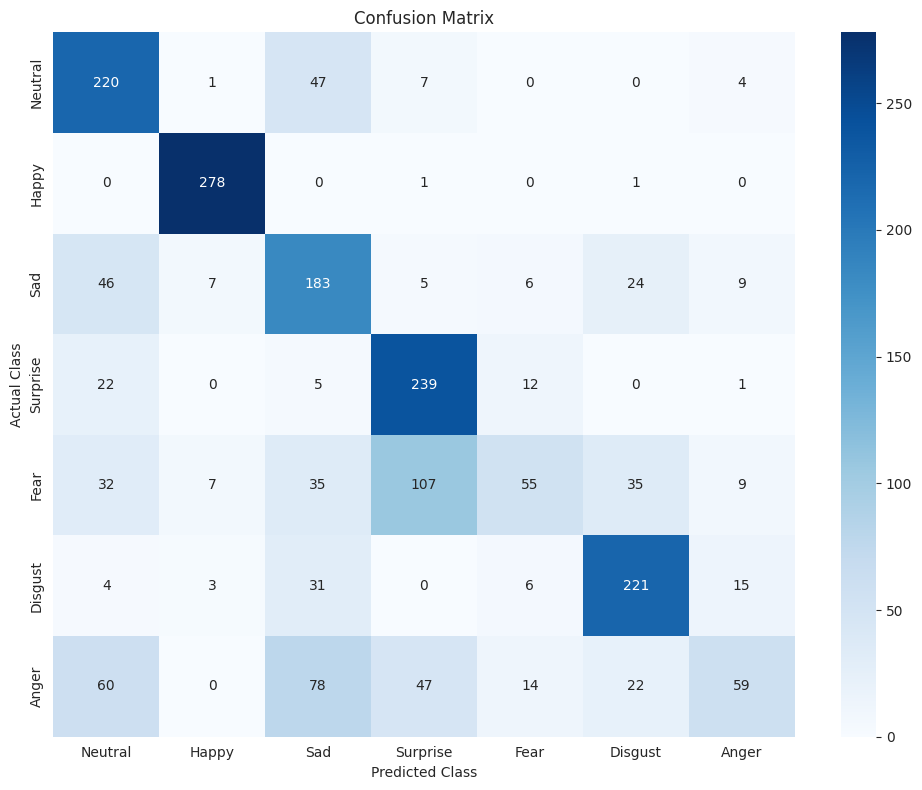

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    class_names = id_to_emotion.values()

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.tight_layout()
    plt.show()

    return fig


cm_figure = plot_confusion_matrix(y_true, y_pred)


In [13]:
result_dir = Path('cross_validation_affectnet_occluded_kdef_occluded')
result_dir.mkdir(exist_ok=True)


def save_evaluation_results(report, cm_figure, checkpoint_dir):
    with (checkpoint_dir / 'classification_report.txt').open(mode='w') as f:
        f.write(report)
    cm_figure.savefig(str(checkpoint_dir / 'confusion_matrix.png'))


save_evaluation_results(report, cm_figure, result_dir)

In [14]:
import shutil

path_to_this_notebook = Path(
    '/home/thor/Desktop/repos/emoji-hero-baseline/kdef_occluded_cross_affectnet_occluded.ipynb')

shutil.copy2(path_to_this_notebook, (result_dir / path_to_this_notebook.name))

PosixPath('cross_validation_affectnet_occluded_kdef_occluded/kdef_occluded_cross_affectnet_occluded.ipynb')